# Preambulo: bibliotecas y lectura del conjunto de datos

In [1]:
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
# importing libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV


In [25]:
df = pd.read_csv('dataset_v2.csv')

# Análisis del conjunto de datos

## Primero veamos los tipos de los datos, rangos y distribuciones de las variables independientes y de la variable dependiente revenue.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        30000 non-null  object 
 1   country        30000 non-null  object 
 2   source         27243 non-null  object 
 3   platform       30000 non-null  object 
 4   device_family  30000 non-null  object 
 5   event_1        30000 non-null  int64  
 6   event_2        30000 non-null  int64  
 7   revenue        30000 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 1.8+ MB


Vemos que hay un conjunto de variables categóricas (country, source, platform y device_family). Para utilizarlas en la regresión tendremos que encodearlas usando OneHotEncoder por ejemplo.

/home/danito/proj/etermax_desafio/etermax_venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_id'>

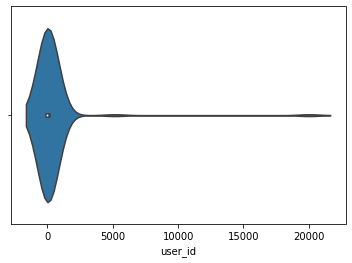

In [4]:
sns.violinplot(df.groupby('country').user_id.count())

Vemos que los usuarios vienen de distintos países pero hay una concentración muy grande los siguientes países España, Francia, México, Argentina e Italia que se llevan casi el 90% de las muestras.

In [5]:
df.groupby('country').user_id.count().sort_values(ascending=False)

country
es    20002
fr     5164
mx      936
ar      693
it      372
      ...  
mc        1
pf        1
ml        1
mt        1
kw        1
Name: user_id, Length: 100, dtype: int64

In [6]:
df.isna().sum()

user_id             0
country             0
source           2757
platform            0
device_family       0
event_1             0
event_2             0
revenue             0
dtype: int64

Vemos que dentro de las variables tenemos el campo source incompleto en un porcentaje. Podemos reemplazar estos valores por la moda aunque también se podrían explorar otros metodos de tipo Missing Not At Random.

In [7]:
df.platform.value_counts()

Android    19880
iOS         8606
android     1070
ios          444
Name: platform, dtype: int64

Vemos que los datos de plataforma no están uniformemente distribuidos. Corregiremos esto facilmente en la preparación de los datos.

In [8]:
df.device_family.value_counts().sort_values(ascending=False).head(20)


Apple iPhone                     7118
Samsung Galaxy Phone             5040
Huawei Phone                     2535
Xiaomi Phone                     2288
Apple iPad                       1446
Samsung Galaxy Tab               1248
Redmi Xiaomi Redmi Note 9 Pro     373
xiaomi Xiaomi Redmi Note 8T       350
Redmi Xiaomi M2003J15SC           322
Samsung Galaxy Note               317
Redmi Xiaomi M2004J19C            263
Motorola Phone                    255
Redmi Xiaomi Redmi Note 9S        215
HUAWEI HUAWEI AGS2-W09            209
samsung samsung SM-A217F          206
samsung samsung SM-T500           185
Apple iPad7,11                    178
Xiaomi Xiaomi Redmi 8             154
OPPO OPPO CPH1941                 147
Apple iPad11,6                    134
Name: device_family, dtype: int64

Vemos que hay mucha pluralidad de dispositivos, podríamos en el futuro generar una variable socioeconómica a partir del modelo del celular. Eligiremos en este modelo sencillo utilizar solamente la variable platform como proxy.

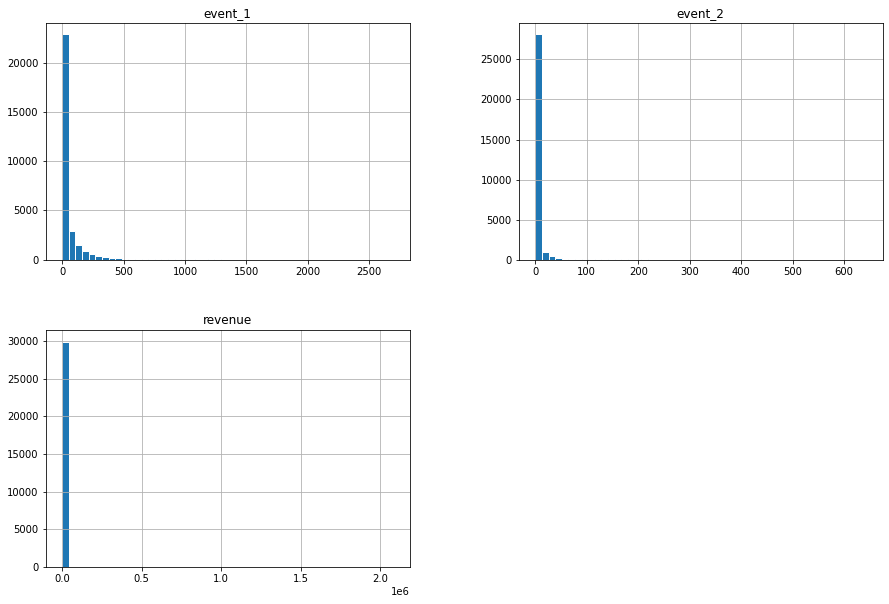

In [9]:
df.hist(bins=50, figsize=(15,10), ec='w')
plt.show()

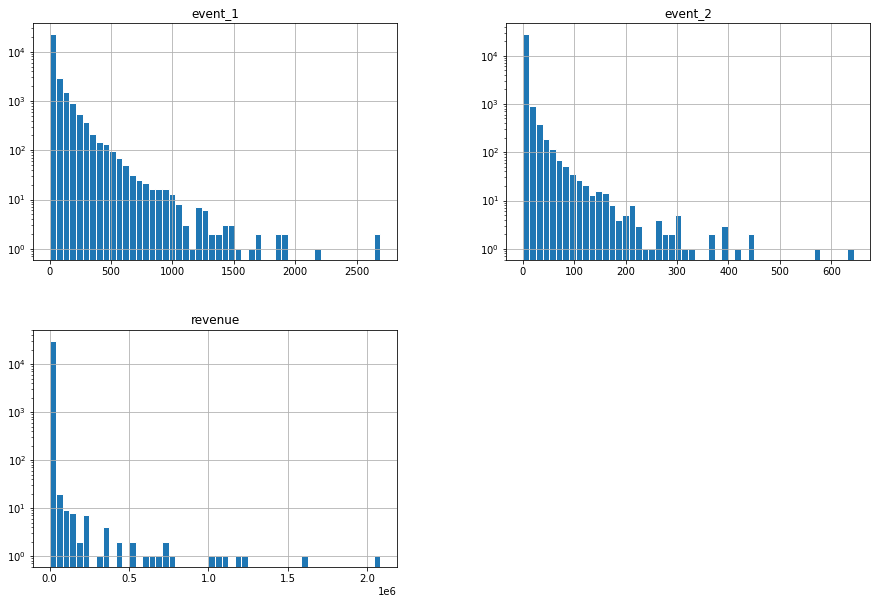

In [10]:
df.hist(bins=50, figsize=(15,10), ec='w',log=True)
plt.show()

<AxesSubplot:ylabel='Frequency'>

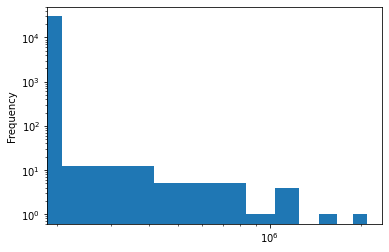

In [11]:
df.revenue.plot(kind='hist',loglog=True)

<AxesSubplot:ylabel='Frequency'>

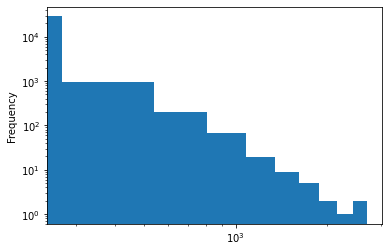

In [12]:
df.event_1.plot(kind='hist',loglog=True)

<AxesSubplot:ylabel='Frequency'>

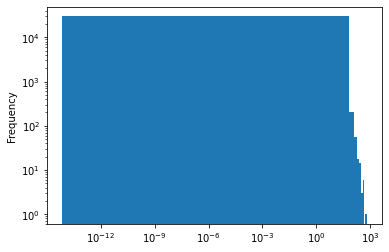

In [13]:
df.event_2.plot(kind='hist',loglog=True)

Podemos ver que revenue, event1 y event2 presentan caracteristicas exponenciales en los histogramas. Podriamos considerar utilizar un modelo log log.

Dentro de las variables numéricas vemos que los eventos (variables potencialmente independientes del modelo) se encuentran en escalas distintas. Podríamos también llevarlas a una escala similar. También observamos que el revenue tiene una distribución de cola pesada.

/home/danito/proj/etermax_desafio/etermax_venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

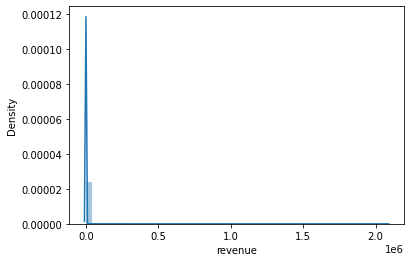

In [14]:
sns.distplot(df.revenue)

<AxesSubplot:xlabel='revenue'>

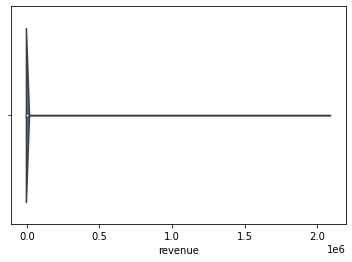

In [15]:
sns.violinplot(x='revenue', data=df)

In [16]:
#Interquartile range
Q1 = df.revenue.quantile(.25)
Q3 = df.revenue.quantile(.95)
IQR = 1.5*(Q3-Q1)
print(f'IQR: {IQR}')
print((df.revenue<IQR).value_counts())

IQR: 0.9432812999999999
True     29187
False      813
Name: revenue, dtype: int64


El IQR es una metrica para determinar outliers muy utilizada. Utilizo un upper bound grande para retener muchos valores de la muestra.

Una opción sería considerar eliminar del conjunto de datos los samples por arriba del IQR (técnica conocida para determinar outliers).

Analicemos ahora la matriz de correlación entre las variables numéricas.

<AxesSubplot:>

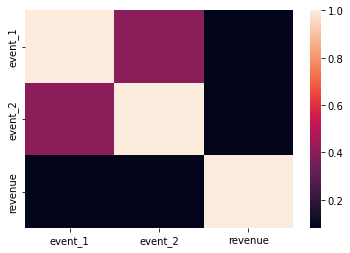

In [17]:
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Vemos una baja correlación entre las variables independientes y revenue. Esto nos hace considerar agregarlas.

# Preparación de los datos
Como hemos visto, la información presenta caracteristicas que deben ser revisadas:

1. Datos faltantes en la columna Source
2. Distintos valores que representan a la misma platform
3. Distintas escalas en event_{1,2} y revenue.
4. Incluir las variables categoricas en el modelo utilizando un one hot encoder (para country, source y platform).

Resolverelos 1 y 2 de manera sencilla pero para el punto 3 consideraremos dos opciones. Una eliminar los outliners por encima del IQR y otra, utilizar un modelo log-log.
Compararemos la precision de ambos modelos y nos quedaremos con el que mejor de.

In [40]:
# Data preparation.
# Uniformizamos los datos de la plataforma.
df.platform = df.platform.str.lower()
# Reemplazamos los valores de source con la moda.
df.source = df.source.fillna(df.source.mode()[0],inplace=False)

# Filtramos outliers en target:
#Interquartile range
Q1 = df.revenue.quantile(.25)
Q3 = df.revenue.quantile(.95)
IQR = 1.5*(Q3-Q1)
df = df[df.revenue<IQR]

In [19]:
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['country',
                             'source',
                             'platform'],use_cat_names=True)
# encode the categorical variables
df = OHE.fit_transform(df)

In [20]:
# create an object of the StandardScaler
scaler = StandardScaler()
scaler.fit(np.array(df.event_1).reshape(-1,1))
df.event_1 = scaler.transform(np.array(df.event_1).reshape(-1,1))
scaler.fit(np.array(df.event_2).reshape(-1,1))
df.event_1 = scaler.transform(np.array(df.event_2).reshape(-1,1))
scaler.fit(np.array(df.event_2).reshape(-1,1))
df.event_1 = scaler.transform(np.array(df.event_2).reshape(-1,1))

# Creando un esqueleto para un pipeline sklearn

In [21]:
def create_train_test_split(data):
    # separate the independent and target variable 
    train_X = data.drop(columns=['user_id','device_family', 'revenue'])
    train_Y = data['revenue']

    # randomly split the data
    train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)
    return train_x, test_x, train_y, test_y


In [22]:
numerical_features = ['event_1', 'event_2']
categorical_features = ['country', 'source', 'platform']

numeric_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

rescaling_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

norescaling_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, categorical_features)
])

In [41]:
model_LR = LinearRegression()

train_x, test_x, train_y, test_y = create_train_test_split(df)

lr_pipeline = Pipeline(steps=[
    ('preprocess', rescaling_processor),
    ('model', model_LR)
])
_ = lr_pipeline.fit(train_x, train_y)
predict_test = lr_pipeline.predict(test_x)
predict_train = lr_pipeline.predict(train_x)

print(mean_absolute_error(train_y, predict_train))
print(mean_absolute_error(test_y, predict_test))

print(lr_pipeline.score(test_x, test_y))

0.030804329720691522
24306450.9219998
-1.4741072534986332e+19


In [42]:
# Transform targets and use same linear model
regr_tran_model = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
)

train_x, test_x, train_y, test_y = create_train_test_split(df)
reg_tran_pipe = Pipeline(steps=[
    ('preprocess', rescaling_processor),
    ('model', regr_tran_model)
])
_ = reg_tran_pipe.fit(train_x, train_y)
predict_test = reg_tran_pipe.predict(test_x)
predict_train = reg_tran_pipe.predict(train_x)

print(mean_absolute_error(train_y, predict_train))
print(mean_absolute_error(test_y, predict_test))

print(reg_tran_pipe.score(test_x, test_y))


0.03187637414110496
0.03308410470425389
0.713428925875774


In [44]:
rfr_model = RandomForestRegressor(max_depth=20)

train_x, test_x, train_y, test_y = create_train_test_split(df)
rfr_pipeline = Pipeline(steps=[
    ('preprocess', rescaling_processor),
    ('model', rfr_model)
])
_ = rfr_pipeline.fit(train_x, train_y)
predict_test = rfr_pipeline.predict(test_x)
predict_train = rfr_pipeline.predict(train_x)

print(mean_absolute_error(train_y, predict_train))
print(mean_absolute_error(test_y, predict_test))

print(rfr_pipeline.score(test_x, test_y))

0.00687074066741683
0.013874009474446454
0.9404394350698446


Concluimos de la comparación de los distintos modelos evaluados que el RandomForestRegressor presenta el menor error en el conjunto de test. Si bien podría haberse reservado un porcentaje de los datos para una verificación final entiendo que este ejemplo no lo amerita y que sí el diseño de una api rest para servir el modelo.
En el archivo server.py encontraremos la implementación del modelo.